In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [4]:
## print(f"Length of training data: {len(train)}")
print(f"Length of test data: {len(test)}")
train.head()

Length of test data: 153164


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1 - train[label_cols].max(axis=1)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [6]:
label_count = dict(train[label_cols + ['none']].sum(axis=0))

In [7]:
#label_count = pd.DataFrame.from_dict(label_count, orient='index', columns = ['count_'])
label_count = pd.DataFrame(list(label_count.items()))
label_count.columns = ['label', 'count_']

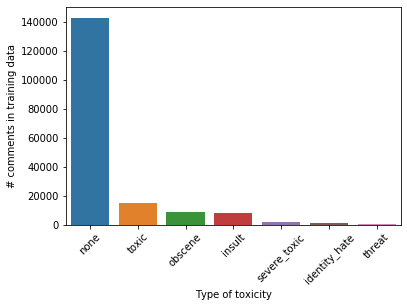

In [8]:
label_count = label_count.sort_values(['count_'], ascending=False).reset_index(drop=True)
sns.barplot(y = label_count.count_, x = label_count.label)
plt.xticks(rotation=45)
plt.xlabel('Type of toxicity')
plt.ylabel('# comments in training data')
plt.show()

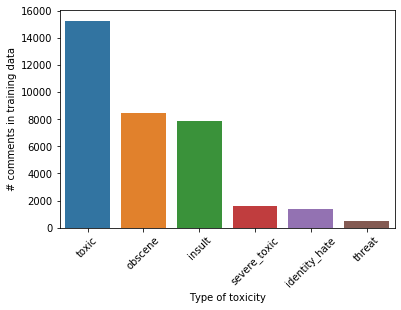

In [11]:
sns.barplot(y = label_count[label_count.label!='none'].count_, x = label_count[label_count.label!='none'].label)
plt.xticks(rotation=45)
plt.xlabel('Type of toxicity')
plt.ylabel('# comments in training data')
plt.show()

In [12]:
print(f"% of non-toxic comments: {100*(label_count.count_[label_count.label=='none'].values[0]/label_count.count_.sum())}%")

% of non-toxic comments: 80.33108426172917%


Almost 20% of comments do not have any toxic label. Also, this problem is a multi-label problem and not a multi-class problem. So a comments can be *toxic* as well as *obscene* for example. There are multiple ways to deal with multi-label classification problems. In this notebook we will be assuming that the toxocity classes are independent of each other and hence will deal with it as six independent binary classification tasks. 

In [13]:
print(train.comment_text.isna().sum())
print(test.comment_text.isna().sum())

0
0


In [14]:
train.comment_text[766]

'"\n\nOh hey, a response. That\'s cool. I personally feel that having the fortitude to call out TTN on his obvious flaws should warrant a few dozen Barnstars, but I see where you\'re coming from. If you insist on keeping the block, I would like to formally request the reason for this account\'s blocking to be changed to reflect the real reason instead of being noted as a common vandal. Maybe a reason along the lines of ""being a pain in the ass"" like that one guy on Nakon\'s talk page stated.\nOn that subject, maybe he should be blocked too, after all he did use a cuss word and that\'s technically worse than anything I\'ve ever said.  -   "'

In [15]:
# remove punctuations and create TF-IDF vectors for unigrams and bigrams

import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

vec = TfidfVectorizer(ngram_range=(1,2), tokenizer = tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train['comment_text'])
test_term_doc = vec.transform(test['comment_text'])

In [16]:
len(vec.vocabulary_)

426005

In [19]:
!pip3 install wordcloud

     |████████████████████████████████| 163kB 1.1MB/s eta 0:00:01


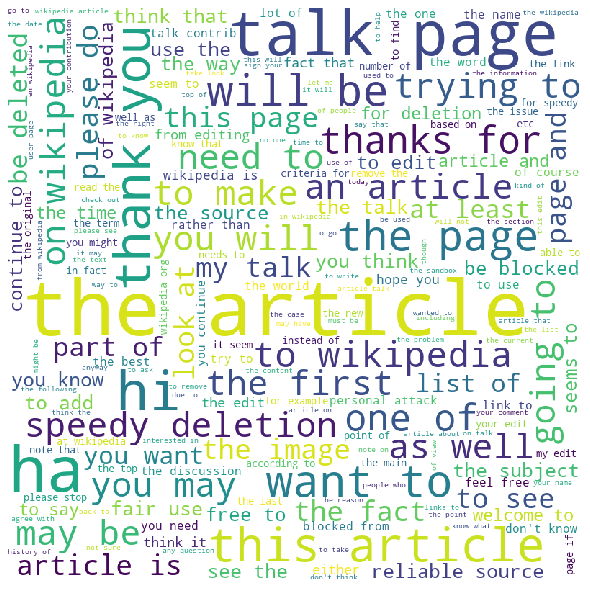

In [26]:
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS) 
stopwords = stopwords.union({'doe', 'wa', 'thi'})
comment_words = '' 
df = train[train.none==1]
for val in df.comment_text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    
    comment_words += " ".join(tokens)+" "
    
    
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [ ]:
x = trn_term_doc
test_x = test_term_doc

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    print(r.shape)
    m = LogisticRegression(C=4, dual=False, solver='newton-cg')
    x_nb = x.multiply(r)
    return (m.fit(x_nb, y), r)

preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.decision_function(test_x.multiply(r))

In [ ]:
!unzip /kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
subm = pd.read_csv('./sample_submission.csv')
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)

In [ ]:
def find_text_(str_, text_):
    return str_ in text_.lower()

cuss= 'retard'
print(train[train['comment_text'].map(lambda x: find_text_(cuss, x)) & train.none==1].shape[0]/train[train['comment_text'].map(lambda x: find_text_('hell', x))].shape[0])
train[train['comment_text'].map(lambda x: find_text_(cuss, x))]


In [ ]:
def count_regexp_occ(regexp="", text=None):
    """ Simple way to get the number of occurence of a regex"""
    text.replace("\n", " ")
    
    return len(re.findall(regexp, text.lower()))



In [ ]:
# find toxic words and create features for each toxic word

bad_words = ['cock', 'shit', 'fuck', 'piss', 'f**k', 's**t', 'suck', 'pussy', 'dick', 'bitch', 'fcuk', 'asshole',
             'dumb', 'faggot', 'retard', 'idiot', 'stupid']

def find_text(str_, text_):
    if str_ in text_.lower():
        return 1
    return 0


In [ ]:
bad_word_features_train = pd.DataFrame()
bad_word_features_test = pd.DataFrame()

for bw in bad_words:
    print(bw)
    bad_word_features_train['feature_'+bw] = train['comment_text'].map(lambda x: find_text(bw, x))
    bad_word_features_test['feature_'+bw] = test['comment_text'].map(lambda x: find_text(bw, x))

In [ ]:
! pip install spacy
! python -m spacy download en_core_web_sm

In [ ]:
import re
train['upper_case'] = train.comment_text.apply(lambda x: count_regexp_occ(r"[A-Z]", x))

In [ ]:
repl = {
    "yay!": " good ",
    "yay": " good ",
    "yaay": " good ",
    "yaaay": " good ",
    "yaaaay": " good ",
    "yaaaaay": " good ",
    ":/": " bad ",
    ":&gt;": " sad ",
    ":')": " sad ",
    ":-(": " frown ",
    ":(": " frown ",
    ":s": " frown ",
    ":-s": " frown ",
    "&lt;3": " heart ",
    ":d": " smile ",
    ":p": " smile ",
    ":dd": " smile ",
    "8)": " smile ",
    ":-)": " smile ",
    ":)": " smile ",
    ";)": " smile ",
    "(-:": " smile ",
    "(:": " smile ",
    ":/": " worry ",
    ":&gt;": " angry ",
    ":')": " sad ",
    ":-(": " sad ",
    ":(": " sad ",
    ":s": " sad ",
    ":-s": " sad ",
    r"\br\b": "are",
    r"\bu\b": "you",
    r"\bhaha\b": "ha",
    r"\bhahaha\b": "ha",
    r"\bdon't\b": "do not",
    r"\bdoesn't\b": "does not",
    r"\bdidn't\b": "did not",
    r"\bhasn't\b": "has not",
    r"\bhaven't\b": "have not",
    r"\bhadn't\b": "had not",
    r"\bwon't\b": "will not",
    r"\bwouldn't\b": "would not",
    r"\bcan't\b": "can not",
    r"\bcannot\b": "can not",
    r"\bi'm\b": "i am",
    "m": "am",
    "r": "are",
    "u": "you",
    "haha": "ha",
    "hahaha": "ha",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "hasn't": "has not",
    "haven't": "have not",
    "hadn't": "had not",
    "won't": "will not",
    "wouldn't": "would not",
    "can't": "can not",
    "cannot": "can not",
    "i'm": "i am",
    "m": "am",
    "i'll" : "i will",
    "its" : "it is",
    "it's" : "it is",
    "'s" : " is",
    "that's" : "that is",
    "weren't" : "were not",
}

new_train_comment = []

for comment in train['comment_text']:
    comment_words = re.split('\W+', comment)
    new_comment = ""
    for word in comment_words:
        if word in repl:
            new_comment += repl[word].lower()
        else:
            new_comment += word.lower()
        new_comment += " "
            
    new_train_comment.append(new_comment)

In [ ]:
new_test_comment = []

for comment in test['comment_text']:
    comment_words = re.split('\W+', comment)
    new_comment = ""
    for word in comment_words:
        if word in repl:
            new_comment += repl[word].lower()
        else:
            new_comment += word.lower()
        new_comment += " "
            
    new_test_comment.append(new_comment)

In [ ]:
word_vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            strip_accents='unicode',
            analyzer='word',
            token_pattern=r'\w{1,}',
            stop_words='english',
            ngram_range=(1, 2),
            max_features=20000)
word_vectorizer.fit(new_train_comment + new_test_comment)
train_word_features = word_vectorizer.transform(new_train_comment)
test_word_features = word_vectorizer.transform(new_test_comment)

In [ ]:
# char_vectorizer = TfidfVectorizer(
#     sublinear_tf=True,
#     strip_accents='unicode',
#     analyzer='char',
#     ngram_range=(2, 6),
#     max_features=20000)
# char_vectorizer.fit(new_train_comment + new_test_comment)
# train_char_features = char_vectorizer.transform(new_train_comment)
# test_char_features = char_vectorizer.transform(new_test_comment)


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from scipy import sparse

In [ ]:
# train_data = hstack([train_word_features, train_char_features, bad_word_features_train]).tocsr()
# test_data = hstack([test_word_features, test_char_features, bad_word_features_test]).tocsr()

train_data = hstack([train_word_features, bad_word_features_train]).tocsr()
test_data = hstack([test_word_features, bad_word_features_test]).tocsr()

In [ ]:
train_word_features.shape

In [ ]:
import lightgbm as lgb

params = {
        "objective": "binary",
        'metric': {'auc'},
        "boosting_type": "gbdt",
        "verbosity": -1,
        "num_threads": 4,
        "bagging_fraction": 0.8,
        "feature_fraction": 0.8,
        "learning_rate": 0.3,
        "num_leaves": 45,
        "verbose": -1,
        "min_split_gain": .1,
        "reg_alpha": .1
    }

In [ ]:
all_results = []
for label in label_cols:
    y_train = train[label]
    dftrainLGB = lgb.Dataset(data = train_data, label = y_train)
    cv_results = lgb.cv(
        params,
        dftrainLGB,
        num_boost_round=200,
        nfold=3,
        metrics='auc',
        early_stopping_rounds=10
        )
    all_results.append(cv_results)
    
sum_auc = 0
for i in range(len(label_cols)):
    sum_auc += max(all_results[i]['auc-mean'])
    
sum_auc/len(label_cols)

In [ ]:
sum_auc = 0
for i in range(len(label_cols)):
    sum_auc += max(all_results[i]['auc-mean'])
    
sum_auc/len(label_cols)